In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
from time import sleep
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from tqdm import tqdm
from torchvision.transforms import ToPILImage
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os,time,sys
# Any results you write to the current directory are saved as output.

In [2]:
Path = "../input/img_align_celeba/"
transform = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) 
])
dset = datasets.ImageFolder(Path, transform)
train_loader = torch.utils.data.DataLoader(dset, batch_size=128, shuffle=True)

In [3]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [4]:
class Gen(nn.Module):
  #attributes (instance variables)
  
  def __init__(self, d = 128) :    
    super(Gen,self).__init__()  
    
    self.deconv1 = nn.ConvTranspose2d(100,d*8, 4 , 1 ,0) ;    
    self.deconv1_bn = nn.BatchNorm2d(d*8)
    self.deconv2 = nn.ConvTranspose2d(d*8,d*4, 4 , 2 ,1) ; 
    self.deconv2_bn = nn.BatchNorm2d(d*4)
    self.deconv3 = nn.ConvTranspose2d(d*4,d*2, 4 , 2 ,1) ;
    self.deconv3_bn = nn.BatchNorm2d(d*2)
    self.deconv4 = nn.ConvTranspose2d(d*2,d, 4 , 2, 1) ;
    self.deconv4_bn = nn.BatchNorm2d(d)     
    self.deconv5 = nn.ConvTranspose2d(d,3,4,2,1);
    
    
  def weight_init(self, mean, std):
    for m in self._modules:
      normal_init(self._modules[m], mean, std);
    
  def forward(self,input):
    
    x = F.relu(self.deconv1_bn(self.deconv1(input)))
    x = F.relu(self.deconv2_bn(self.deconv2(x)))
    x = F.relu(self.deconv3_bn(self.deconv3(x)))
    x = F.relu(self.deconv4_bn(self.deconv4(x)))
    x = F.tanh(self.deconv5(x))
    
    return x;
  

In [5]:
class Disc (nn.Module) :
  # initializers
    def __init__(self, d=128):
        super(Disc, self).__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    # weight_init --> again can be done directly and avoid all this bullshit
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))

        return x

In [6]:
batch_size = 128
lr = 0.00015
train_epoch = 25


# Define the models
G = Gen(128)
D = Disc(128)
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)
G.cuda()
D.cuda()

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))


In [7]:
def show_result(num_epoch, show = False, save = False, path = 'result.png', isFix=False):
    z_ = torch.randn((5*5, 100)).view(-1, 100, 1, 1)
    z_ = Variable(z_.cuda(), volatile=True)

    G.eval()
    test_images = G(z_)
    G.train()

    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(5*5):
        i = k // 5
        j = k % 5
        ax[i, j].cla()
        ax[i, j].imshow((test_images[k].cpu().data.numpy().transpose(1, 2, 0) + 1) / 2)

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()


  0%|          | 0/1583 [00:00<?, ?it/s]

Training start!


/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

100%|██████████| 1583/1583 [16:03<00:00,  1.91it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


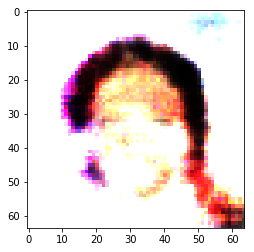

 57%|█████▋    | 904/1583 [07:32<02:43,  4.15it/s]


In [8]:
print('Training start!')



start_time = time.time()
for epoch in tqdm(range(train_epoch)):
    D_losses = []
    G_losses = []

    # learning rate decay (First we make it smaller at the 10th and 15th ephoch)
    if (epoch+1) == 11:
        G_optimizer.param_groups[0]['lr'] /= 10
        D_optimizer.param_groups[0]['lr'] /= 10
        print("learning rate change!")

    if (epoch+1) == 16:
        G_optimizer.param_groups[0]['lr'] /= 10
        D_optimizer.param_groups[0]['lr'] /= 10
        print("learning rate change!")

    num_iter = 0
    
    
    
    for x_, _ in tqdm(train_loader):
        if(num_iter == 649 ):
            continue;
        # train discriminator D
        D.zero_grad() 
        mini_batch = x_.size()[0]

        y_real_ = torch.ones(mini_batch)
        y_fake_ = torch.zeros(mini_batch)

        x_, y_real_, y_fake_ = Variable(x_.cuda()), Variable(y_real_.cuda()), Variable(y_fake_.cuda())
        D_result = D(x_).squeeze()
        D_real_loss = BCE_loss(D_result, y_real_)

        z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)
        z_ = Variable(z_.cuda())
        
        G_result = G(z_)
        D_result = D(G_result).squeeze()
        D_fake_loss = BCE_loss(D_result, y_fake_)
        D_fake_score = D_result.data.mean()
        D_train_loss = D_real_loss + D_fake_loss
        D_train_loss.backward()
        D_optimizer.step()
        D_losses.append(D_train_loss.data.item())
        
        
        # train generator G
        G.zero_grad()

        z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)
        z_ = Variable(z_.cuda())

        G_result = G(z_)
        D_result = D(G_result).squeeze()
        G_train_loss = BCE_loss(D_result, y_real_)
        G_train_loss.backward()
        G_optimizer.step()
        G_losses.append(G_train_loss.data.item())
        
        num_iter += 1
        
#         pil_im = ToPILImage()
#         plt.imshow(pil_im((G_result[0].cpu().data.numpy().transpose(1, 2, 0) + 1).astype('uint8')))
#         sleep(2)
    plt.figure()
    plt.imshow(G_result[0].cpu().data.numpy().transpose(1, 2, 0) + 1)
    plt.show();

In [9]:
# plt.figure()
# plt.imshow(G_result[1:5].cpu().data.numpy().transpose(1, 2, 0) + 1)
# plt.show();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


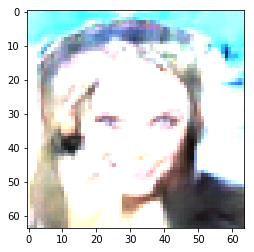

In [10]:
pil_im = ToPILImage()
plt.imshow((G_result[12].cpu().data.numpy().transpose(1, 2, 0) + 1))
